In [3]:
import json
import random
from glob import glob
import os
import multiprocessing as mp
from time import time

In [4]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from rdkit.Chem.AllChem import ReactionFromSmarts
from rdkit.Chem import CanonSmiles
from rdkit import Chem

from ord_data_load import df_na_vals, parse_pb_file
from ord_data_load import ORD_PATH, ORD_REPO_PATH

%load_ext autoreload
%autoreload 2

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
#to disable warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

## Load and clean data

In [137]:
#TODO load those files ~ 500k reactions from https://doi.org/10.1039/C8SC04228D
# parse_pb_file(glob(f'{ORD_REPO_PATH}/data/*/*de0979205c84441190feef587fef8d6d.pb.gz')[0], ORD_PATH)
# parse_pb_file(glob(f'{ORD_REPO_PATH}/data/*/*488402f6ec0d441ca2f7d6fabea7c220.pb.gz')[0], ORD_PATH)
# parse_pb_file(glob(f'{ORD_REPO_PATH}/data/*/*5481550056a14935b76e031fb94b88be.pb.gz')[0], ORD_PATH)

ord_dataset-5481550056a14935b76e031fb94b88be extraction failed with error: 'conditions'


In [8]:
""" Multiprocessing """
start = time()

n_cores = 24
args = [(pb, ORD_PATH) for pb in glob(f'{ORD_REPO_PATH}/data/*/*.pb.gz')]
N = len(args)

with mp.Pool(n_cores) as p:
    p.starmap(parse_pb_file, args)

t = time() - start
s = int(t % 60)
m = int((t // 60) % 60)
h = int((t // 60) / 60)
print(f'{N} datasets parsed in {h:02d}h:{m:02d}m:{s:02d}s')

515 datasets parsed in 00h:09m:39s


In [9]:
dataset_paths = sorted(glob(f'{ORD_PATH}/parsed/*.json'))
N = len(dataset_paths)
print(N)

506


In [10]:
start = time()
all_reactions = dd.read_json(
    dataset_paths,
    orient='columns',
    dtype='object',
    include_path_column=True,
    path_converter=lambda x: os.path.split(x)[1].split('.')[0]
).rename(columns={'path': 'original_dataset'}).compute(scheduler='threads')
all_reactions.reset_index(inplace=True, drop=True)

t = time() - start
s = int(t % 60)
m = int((t // 60) % 60)
h = int((t // 60) / 60)
print(f'{N} datasets parsed in {h:02d}h:{m:02d}m:{s:02d}s')

506 datasets parsed in 00h:00m:58s


In [11]:
print(all_reactions.shape)
df_na_vals(all_reactions, False)

(1790148, 13)
id                    ->         Missing values: 0 (0.00%)
reaction_smile        ->         Missing values: 19116 (1.07%)
solvents              ->         Missing values: 404697 (22.61%)
reactants             ->         Missing values: 0 (0.00%)
catalysts             ->         Missing values: 1523003 (85.08%)
reagents              ->         Missing values: 1773144 (99.05%)
temperature           ->         Missing values: 687161 (38.39%)
time                  ->         Missing values: 897258 (50.12%)
product               ->         Missing values: 40191 (2.25%)
yield                 ->         Missing values: 816308 (45.60%)
notes                 ->         Missing values: 12044 (0.67%)
patent                ->         Missing values: 19116 (1.07%)
original_dataset      ->         Missing values: 1790148 (100.00%)


In [22]:
all_reactions.set_index('id', inplace=True, verify_integrity=True)

In [23]:
%%time
pd.to_pickle(all_reactions, f'{ORD_PATH}/all_reactions.pkl')

# Inspect dataset

## generate reaction smiles

In [19]:
%%time
all_reactions = pd.read_pickle(f'{ORD_PATH}/all_reactions.pkl')

CPU times: total: 17.7 s
Wall time: 17.7 s


In [20]:
rxn_na = all_reactions['reaction_smile'].isna()
rxn_na.sum()

19116

In [21]:
print(all_reactions.loc[rxn_na, 'reactants'].isna().sum())
print(all_reactions.loc[rxn_na, 'product'].isna().sum())
all_reactions.loc[rxn_na]

0
0


,reaction_smile,solvents,reactants,catalysts,reagents,temperature,time,product,yield,notes,patent,original_dataset
id,,,,,,,,,,,,
ord-56b1f4bfeebc4b8ab990b9804e798aa7,None,[],"[[None, CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=C(C=C(C=...","[[None, C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=...","[[None, C(=O)([O-])[O-].[Cs+].[Cs+]]]",110.0,None,CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=C(C=C(C=C3)F)F)C...,65.39,"To a solution of ethyl 6-bromo-4-(2,4-difluoro...",None,ord_dataset-00005539a1e04c809a9a78647bea649c
ord-1169cbe9fa064a879ac34b2e524a4e69,None,"[[None, COC1=CC=CC=C1]]","[[None, CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC], [Non...","[[None, CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=...","[[None, C(=O)([O-])[O-].[Cs+].[Cs+]]]",100.0,None,CN1C=NC2=C1C=C(C(=C2F)NC3=CC=CC=C3)C(=O)OC,57.47,"9,9-Dimethyl-4,5-bis(diphenylphosphino)xanthen...",None,ord_dataset-00005539a1e04c809a9a78647bea649c
ord-13992005c22d4673aa802b5e140076e8,None,"[[None, COC1=CC=CC=C1]]","[[None, CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC], [Non...","[[None, CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=...","[[None, C(=O)([O-])[O-].[Cs+].[Cs+]]]",100.0,None,CN1C=NC2=C1C=C(C(=C2F)NC3=CC=CC=C3)C(=O)OC,65.43,"9,9-Dimethyl-4,5-bis(diphenylphosphino)xanthen...",None,ord_dataset-00005539a1e04c809a9a78647bea649c
ord-a36b48917c9942d1a34637511773ee1f,None,"[[None, COC1=CC=CC=C1]]","[[None, CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC], [Non...","[[None, CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=...","[[None, C(=O)([O-])[O-].[Cs+].[Cs+]]]",100.0,None,CN1C=NC2=C1C=C(C(=C2F)NC3=CC=CC=C3)C(=O)OC,75.07,"9,9-Dimethyl-4,5-bis(diphenylphosphino)xanthen...",None,ord_dataset-00005539a1e04c809a9a78647bea649c
ord-5fc624fd97b7430eafbe8dcc049d170b,None,"[[None, CC(=O)N(C)C]]","[[None, CC1=NC(=C(C=C1)OC2=CC(=NC=C2)Cl)C], [N...","[[None, CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=...","[[None, C(=O)([O-])[O-].[Cs+].[Cs+]]]",150.0,None,CC1=NC(=C(C=C1)OC2=CC(=NC=C2)NC3=CC=C(C=C3)S(=...,46.32,"3-(2-chloropyridin-4-yloxy)-2,6-dimethylpyrid...",None,ord_dataset-00005539a1e04c809a9a78647bea649c
...,...,...,...,...,...,...,...,...,...,...,...,...
ord-0c7156c1a1f2475c874996afe0b7bca6,None,"[[THF, C1CCCO1], [THF, C1CCCO1]]","[[None, O[C@H]1C[C@@H](C(OC)=O)N(C(OC(C)(C)C)=...",[],"[[BTPP, CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3]]",AMBIENT,48.0,F[C@H]1C[C@@H](C(OC)=O)N(C(OC(C)(C)C)=O)C1,32.0,None,None,ord_dataset-fc83743b978f4deea7d6856deacbfe53
ord-e1c475b70bee4cc0adc37dd3eeb4b39e,None,"[[THF, C1CCCO1], [THF, C1CCCO1]]","[[perfluorobutane-1-sulfonyl fluoride, C(C(C(F...",[],"[[DBU, N\2=C1\N(CCCCC1)CCC/2]]",AMBIENT,48.0,F[C@H]1C[C@@H](C(OC)=O)N(C(OC(C)(C)C)=O)C1,59.0,None,None,ord_dataset-fc83743b978f4deea7d6856deacbfe53
ord-8970dc6e6fc947adb89f4dd248d06b24,None,"[[THF, C1CCCO1], [THF, C1CCCO1]]","[[perfluorobutane-1-sulfonyl fluoride, C(C(C(F...",[],"[[MTBD, CN1CCCN2C1=NCCC2]]",AMBIENT,48.0,F[C@H]1C[C@@H](C(OC)=O)N(C(OC(C)(C)C)=O)C1,74.0,None,None,ord_dataset-fc83743b978f4deea7d6856deacbfe53


CC(=O)c1ccc(F)cc1Br.CCN(CC)c1ccc2OC(=O)C(=Cc2c1)c3sc4ccccc4n3>CS(=O)C.CN(C)C=O.CCC1=CN=C(C2=CC=CC(OC)=C2)C=C1.CCCCCCCCCC1=CC(C2=CC(CCCCCCCCC)=CC=N2)=NC=C1.O.Cl[Ir](Cl)Cl.CCN(C(C)C)C(C)C>[Br-].CCN(CC)c1ccc2OC(=O)C(=Cc2c1)c3sc4ccccc4[nH+]3


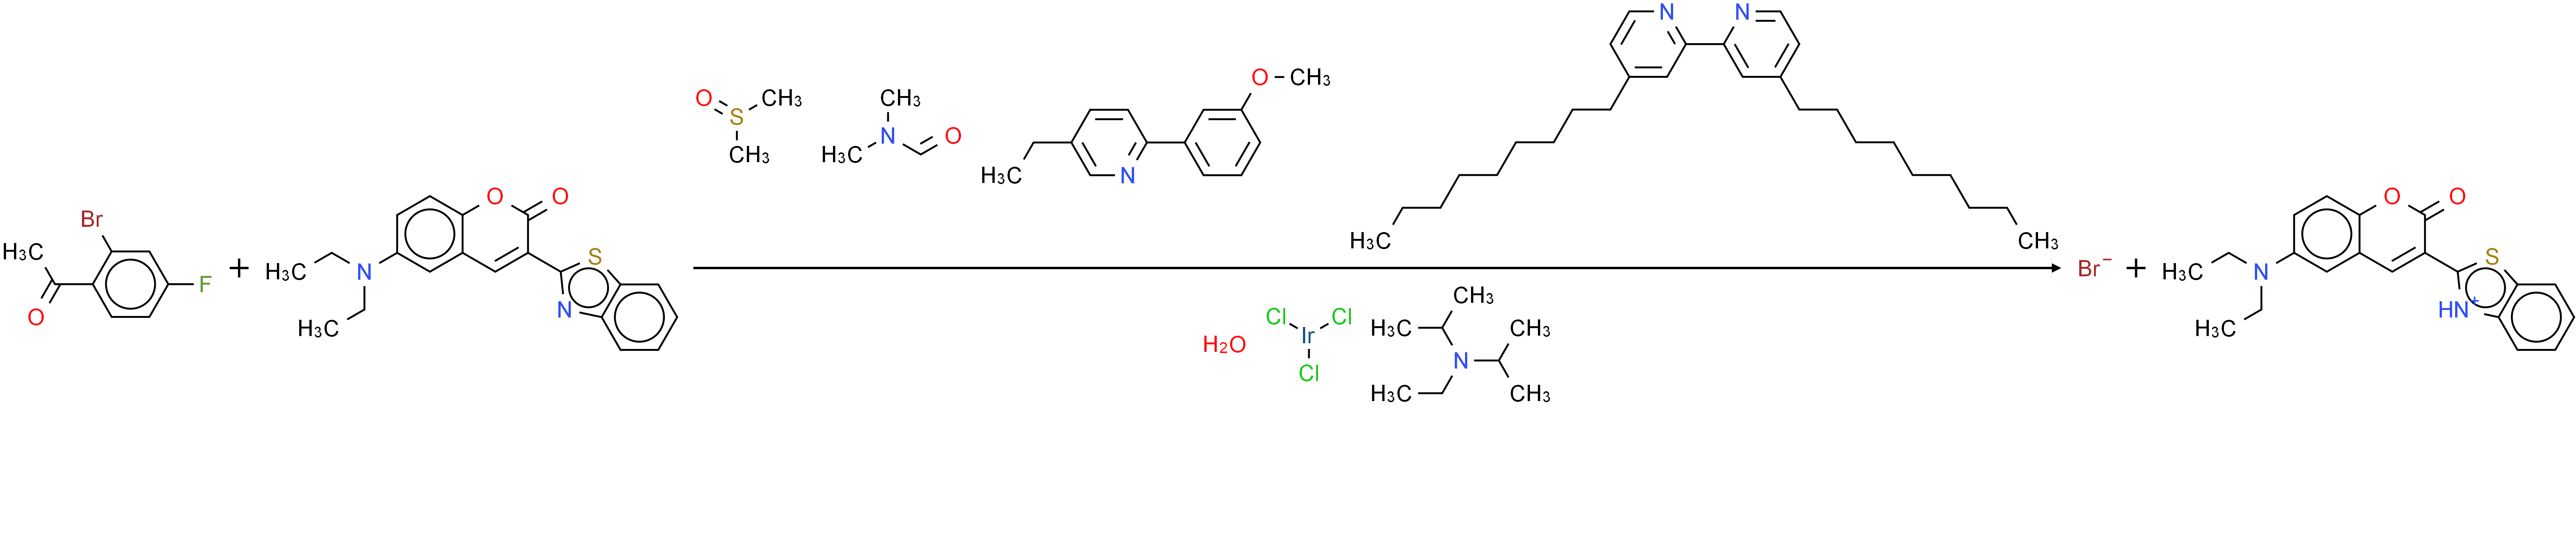

In [23]:
# Generate reaction smiles
from chem_render import draw_reaction_smi, draw_mol

smile_cols = ['reactants', 'solvents', 'catalysts', 'reagents']

def parse_column(row, col_name: str):
    smiles = ""
    for r in row[col_name]:
        if r[1]:
            # smiles += f"[{r[1]}]."
            smiles += f"{r[1]}."
    return smiles

def generate_rxn_smile(row):
    rxn_smile = ""
    rxn_smile = parse_column(row, 'reactants')

    rxn_smile = rxn_smile[:-1] # strip last "."
    rxn_smile += ">"

    for col in ['solvents', 'catalysts', 'reagents']:
        rxn_smile += parse_column(row, col)

    rxn_smile = rxn_smile[:-1] # strip last "."
    rxn_smile += ">"

    rxn_smile += row['product']
    return rxn_smile

row = all_reactions.loc[rxn_na].sample().iloc[0]
rxn_smile = generate_rxn_smile(row)
print(rxn_smile)
draw_reaction_smi(rxn_smile)

In [120]:
%%time
# check reagent, product etc. smiles
from chem_render import indigo

errors = {}
error_smi =[]
error_df = pd.DataFrame(columns=['idx', 'col', 'smiles', 'type'])

for (idx, row) in all_reactions.loc[rxn_na].iterrows():
    for col in ['solvents', 'catalysts', 'reagents', 'reactants']:
        if row[col]:
            for cmpd in row[col]:
                if cmpd:
                    if cmpd[1]:
                        try:
                            # Chem.MolFromSmiles(cmpd[1])
                            smi = cmpd[1]
                            indigo.loadMolecule(smi)
                        except Exception as e:
                            error_df.loc[len(error_df)] = [idx, col, smi, str(e)]
    try:
        col = 'product'
        smi = row[col]
        indigo.loadMolecule(smi)
        # ReactionFromSmarts(generate_rxn_smile(row))
    except Exception as e:
        error_df.loc[len(error_df)] = [idx, col, smi, str(e)]

print(len(error_df))

5872
CPU times: total: 30.4 s
Wall time: 30.4 s


In [121]:
print(error_df.type.unique())
print(error_df.col.unique())

["molecule auto loader: SMILES loader: invalid character within atom description: '>'"
 "molecule auto loader: SMILES loader: invalid character within atom description: '<'"]
['catalysts' 'reagents']


## Dative bond smiles
Smile signs "->" and "<-" are specific SMILES extension by RDkit
Solution - drop dative bond signs, as in Pharma they use "metal" - "ligand" smiles combination

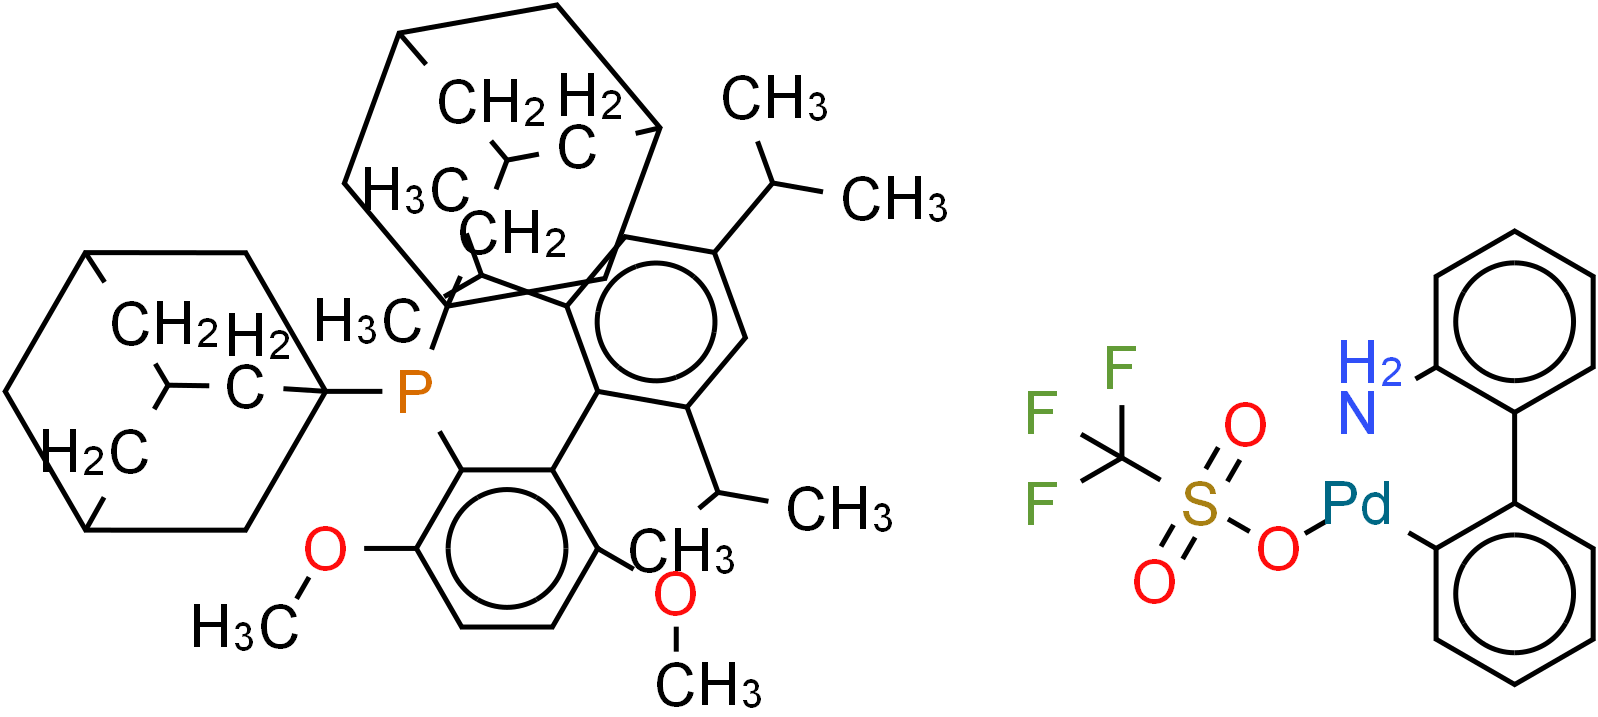

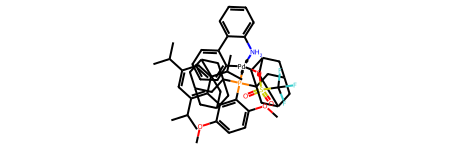

In [116]:
import random
smi = random.choice(error_df['smiles'])
draw_mol(smi.replace("->", ".").replace("<-", "."))
Chem.MolFromSmiles(smi)

In [135]:
# drop dative bonds
def drop_dative_bonds(cmpds):
    return [[x[0], x[1].replace("->", ".").replace("<-", ".")] for x in cmpds]

for col in error_df['col'].unique():
    mask = error_df.loc[error_df.col == col, 'idx']
    all_reactions.loc[mask, col] = all_reactions.loc[mask, col].apply(drop_dative_bonds)


Cc1ccc(N)cc1.COc1ccc(Br)cc1>CS(=O)C.CS(=O)C.CS(=O)C.CS(=O)C.CS(=O)C.COc1ccc(OC)c(P(C(C)(C)C)(C(C)(C)C).[Pd]2(OS(=O)(=O)C(F)(F)F).Nc3ccccc3-c3ccccc32)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.COC(=O)c1cc(-c2ccco2)on1>COc1ccc(Nc2ccc(C)cc2)cc1


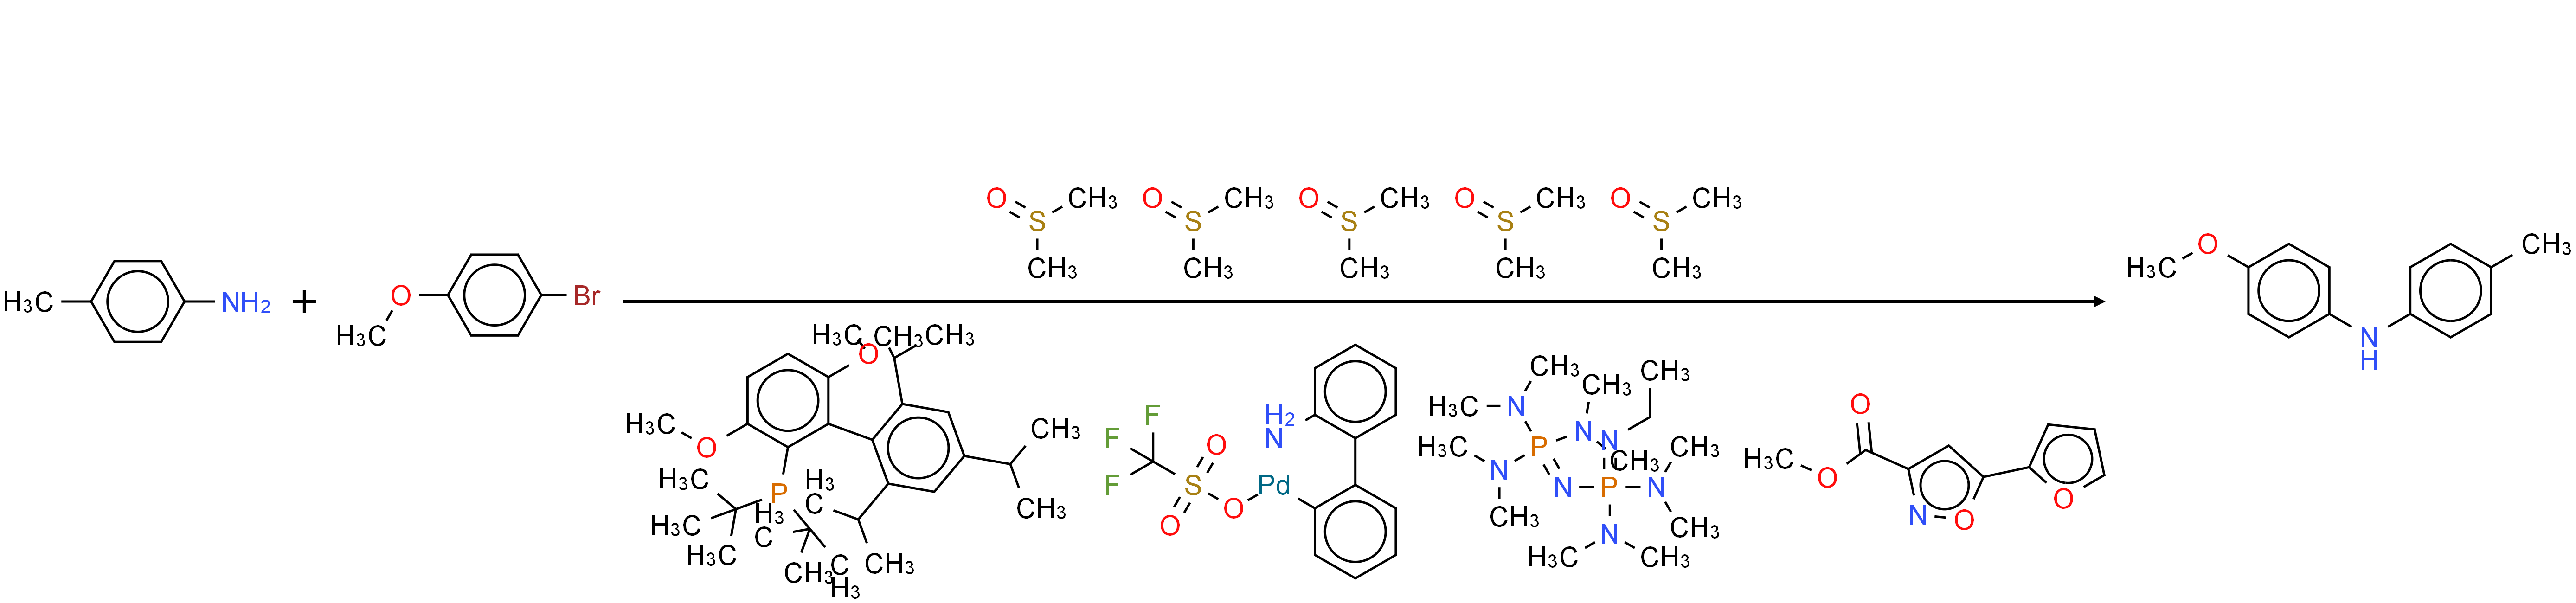

In [145]:
# check random reactions from previous errors
idx = random.choice(error_df['idx'])
row = all_reactions.loc[idx]
rxn_smile = generate_rxn_smile(row)
print(rxn_smile)
draw_reaction_smi(rxn_smile)

In [154]:
%%time
# test for errors
rxn_smiles = all_reactions.loc[rxn_na].apply(generate_rxn_smile, axis=1)
for rxn_smile in rxn_smiles:
    try:
        indigo.loadReaction(rxn_smile)
    except Exception as e:
        print(f"Error loading reaction: {e}")
        break
print("OK")

OK
CPU times: total: 17.6 s
Wall time: 17.6 s


In [155]:
all_reactions.loc[rxn_na, 'reaction_smile'] = all_reactions.loc[rxn_na].apply(generate_rxn_smile, axis=1)

In [157]:
%%time
# save intermediate result
pd.to_pickle(all_reactions, f'{ORD_PATH}/all_reactions.pkl')

CPU times: total: 17.2 s
Wall time: 17.2 s


## Wrong product
We need to extract the product with flag "is_desired_product" = True
from quality datasets with multiple outcomes.

In [25]:
#TODO We need to extract the product with flag "is_desired_product" = True from quality datasets with multiple outcomes.

mask = all_reactions.original_dataset == "ord_dataset-7d8f5fd922d4497d91cb81489b052746"
all_reactions.loc[mask]

,reaction_smile,solvents,reactants,catalysts,reagents,temperature,time,product,yield,notes,patent,original_dataset
id,,,,,,,,,,,,
ord-62a27aab55d94574b2b57fcdf70bc856,None,"[[DMSO, CS(C)=O], [DMSO, CS(C)=O], [DMSO, CS(C...","[[amine S1, CC(N)CCc1ccccc1], [bromide 22, Brc...",[],"[[BINAP Pd G3 30, CS(=O)(=O)O[Pd]1(<-P(C2=CC=C...",AMBIENT,22.0,c1ccc(-c2ccccc2)cc1,None,The Mosquito was used to combine the source pl...,None,ord_dataset-7d8f5fd922d4497d91cb81489b052746
ord-114610bcc8ba4eb9b09fec460cd63226,None,"[[DMSO, CS(C)=O], [DMSO, CS(C)=O], [DMSO, CS(C...","[[amine S1, CC(N)CCc1ccccc1], [bromide 22, Brc...",[],"[[BINAP Pd G3 30, CS(=O)(=O)O[Pd]1(<-P(C2=CC=C...",AMBIENT,22.0,c1ccc(-c2ccccc2)cc1,None,The Mosquito was used to combine the source pl...,None,ord_dataset-7d8f5fd922d4497d91cb81489b052746
ord-05e49b63873c4286a70e207fdda55ac1,None,"[[DMSO, CS(C)=O], [DMSO, CS(C)=O], [DMSO, CS(C...","[[bromide 22, Brc1cccnc1], [amine S1, CC(N)CCc...",[],"[[BINAP Pd G3 30, CS(=O)(=O)O[Pd]1(<-P(C2=CC=C...",AMBIENT,22.0,c1ccc(-c2ccccc2)cc1,None,The Mosquito was used to combine the source pl...,None,ord_dataset-7d8f5fd922d4497d91cb81489b052746
ord-4c0bfb1703ca4be8a78075d4a804d13f,None,"[[DMSO, CS(C)=O], [DMSO, CS(C)=O], [DMSO, CS(C...","[[bromide 22, Brc1cccnc1], [amine S1, CC(N)CCc...",[],"[[BINAP Pd G3 30, CS(=O)(=O)O[Pd]1(<-P(C2=CC=C...",AMBIENT,22.0,c1ccc(-c2ccccc2)cc1,None,The Mosquito was used to combine the source pl...,None,ord_dataset-7d8f5fd922d4497d91cb81489b052746
ord-3737da5147cb48b28725c90c3d98d9c1,None,"[[DMSO, CS(C)=O], [DMSO, CS(C)=O], [DMSO, CS(C...","[[amine S1, CC(N)CCc1ccccc1], [bromide 22, Brc...",[],"[[BINAP Pd G3 30, CS(=O)(=O)O[Pd]1(<-P(C2=CC=C...",AMBIENT,22.0,c1ccc(-c2ccccc2)cc1,None,The Mosquito was used to combine the source pl...,None,ord_dataset-7d8f5fd922d4497d91cb81489b052746
...,...,...,...,...,...,...,...,...,...,...,...,...
ord-643348c47c0d4f98aed8a711939d2302,None,"[[DMSO, CS(C)=O], [DMSO, CS(C)=O], [DMSO, CS(C...","[[alkyne S16, C#Cc1ccc(CCCC)cc1], [bromide 22,...",[],"[[AdBrettPhos Pd G3 45, COC1=CC=C(OC)C(P(C23C[...",AMBIENT,22.0,c1ccc(-c2ccccc2)cc1,None,The Mosquito was used to combine the source pl...,None,ord_dataset-7d8f5fd922d4497d91cb81489b052746
ord-bd86d2743ef4430e815c6783a01a7610,None,"[[DMSO, CS(C)=O], [DMSO, CS(C)=O], [DMSO, CS(C...","[[alkyne S16, C#Cc1ccc(CCCC)cc1], [bromide 22,...",[],"[[BTMG 26, CN(C)C(=NC(C)(C)C)N(C)C], [AdBrettP...",AMBIENT,22.0,c1ccc(-c2ccccc2)cc1,None,The Mosquito was used to combine the source pl...,None,ord_dataset-7d8f5fd922d4497d91cb81489b052746
ord-91c8ce372fd84bf2b2fc30935d9f7ac5,None,"[[DMSO, CS(C)=O], [DMSO, CS(C)=O], [DMSO, CS(C...","[[bromide 22, Brc1cccnc1], [alkyne S16, C#Cc1c...",[],"[[AdBrettPhos Pd G3 45, COC1=CC=C(OC)C(P(C23C[...",AMBIENT,22.0,c1ccc(-c2ccccc2)cc1,None,The Mosquito was used to combine the source pl...,None,ord_dataset-7d8f5fd922d4497d91cb81489b052746


Reactans:


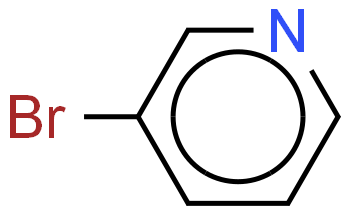

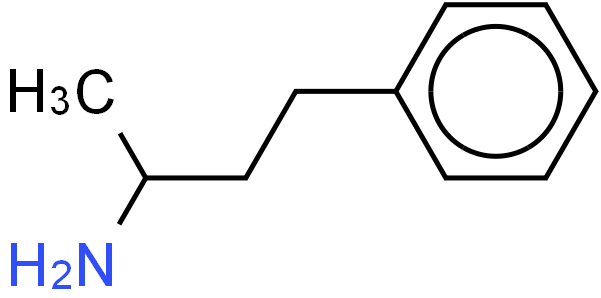

In [40]:
print("Reactans:")
draw_mol(all_reactions.loc[mask, 'reactants'].iat[4][1][1])
draw_mol(all_reactions.loc[mask, 'reactants'].iat[4][0][1])

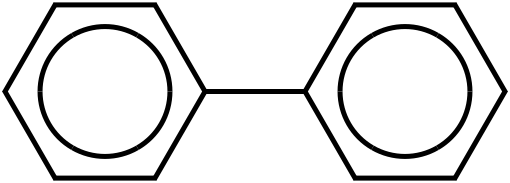

In [39]:
# the only product for the whole dataset - in fact it is internal standard
draw_mol(all_reactions.loc[mask, 'product'].unique()[0])